In [1]:
# Example of fitting double-slit diffraction data
# Version using scipy.optimize.minimize directly

In [2]:
from pathlib import Path
import numpy as np
import csv
import matplotlib.pyplot as plt
import scipy.optimize as opt

In [3]:
datafile = Path('data/double slit 15ish inches green laser.csv')

In [4]:
# read the datafile and convert to a numpy array with the right shape
with open(datafile) as file:
    reader = csv.reader(file)
    data = [i for i in reader]

data = np.array(data).astype(float).T

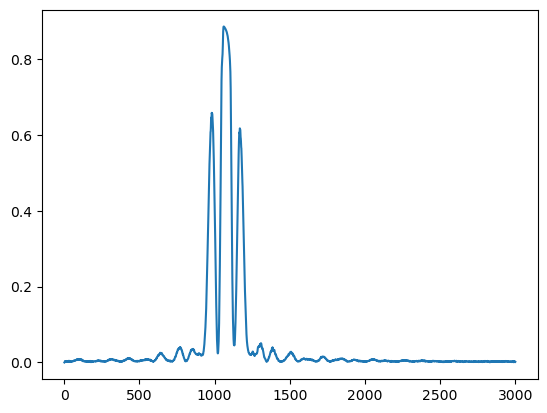

In [5]:
plt.plot(data[0],data[1])

In [6]:
def fit(x,a,b,c,d,f):
    # NB use numpy's sinc function to avoid divide-by-zero errors.  Note extra factor of pi.
    return b*(np.sinc(c*(x-d)/np.pi)**2*np.cos(a*(x-d))**2)+f

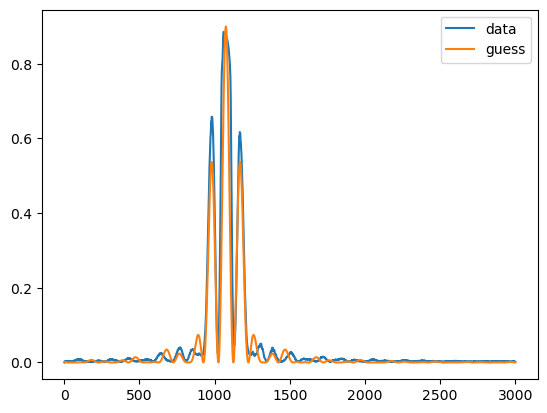

In [7]:
# Michael's best guess
guess = [0.0315,0.9,0.0125,1075,0]

fig, ax = plt.subplots()
ax.plot(data[0],data[1],label='data')
ax.plot(data[0],fit(data[0],*guess),label='guess')
ax.legend()

There are a couple of different algoritms available in `scipy.optimize`.  Here are two commonly used:
- `scipy.optimize.least_squares': https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
- `scipy.optimize.minimize': https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

Note that `scipy.optimize.curve_fit` is just a wrapper for these two functions, depending the value of `method`.  If you prefer to use `curve_fit`, you may pass on additional paramters to the algorithms by adding them to the end of the parameter list.

First example, using `curve_fit`.

In [8]:
result = opt.curve_fit(fit, data[0], data[1], p0 = guess,
                       full_output = True,
                      epsfcn = 1e-12) # this sets the step size, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html

In [9]:
# parameter values
result[0]

array([2.99779323e-02, 1.10362570e+00, 1.31283060e-02, 1.07580696e+03,
       5.95865513e-03])

In [10]:
# covariance matrix of the parameters
print(result[1])

[[ 3.45327500e-09 -1.88601939e-10 -4.57119147e-12  2.51401506e-09
  -2.54754639e-13]
 [-1.88601939e-10  3.28957202e-05  1.84962190e-07  8.44385909e-08
  -6.93840118e-07]
 [-4.57119147e-12  1.84962190e-07  4.78210007e-09  1.15362715e-09
   8.14657707e-09]
 [ 2.51401506e-09  8.44385909e-08  1.15362715e-09  1.53937205e-02
  -1.27950111e-08]
 [-2.54754639e-13 -6.93840118e-07  8.14657707e-09 -1.27950111e-08
   5.27198705e-07]]


In [11]:
# full results output
result

(array([2.99779323e-02, 1.10362570e+00, 1.31283060e-02, 1.07580696e+03,
        5.95865513e-03]),
 array([[ 3.45327500e-09, -1.88601939e-10, -4.57119147e-12,
          2.51401506e-09, -2.54754639e-13],
        [-1.88601939e-10,  3.28957202e-05,  1.84962190e-07,
          8.44385909e-08, -6.93840118e-07],
        [-4.57119147e-12,  1.84962190e-07,  4.78210007e-09,
          1.15362715e-09,  8.14657707e-09],
        [ 2.51401506e-09,  8.44385909e-08,  1.15362715e-09,
          1.53937205e-02, -1.27950111e-08],
        [-2.54754639e-13, -6.93840118e-07,  8.14657707e-09,
         -1.27950111e-08,  5.27198705e-07]]),
 {'fvec': array([0.00862203, 0.00845109, 0.00793936, ..., 0.00405491, 0.00520531,
         0.00431724]),
  'nfev': 37,
  'fjac': array([[ 6.41551978e+02,  9.27798446e-03,  9.24665634e-03, ...,
           4.54442409e-05,  5.53900215e-05,  6.54069930e-05],
         [ 6.32736682e-01,  6.41026654e+02,  1.67521577e-04, ...,
          -2.38588003e-04, -2.39250440e-04, -2.34663429e-04

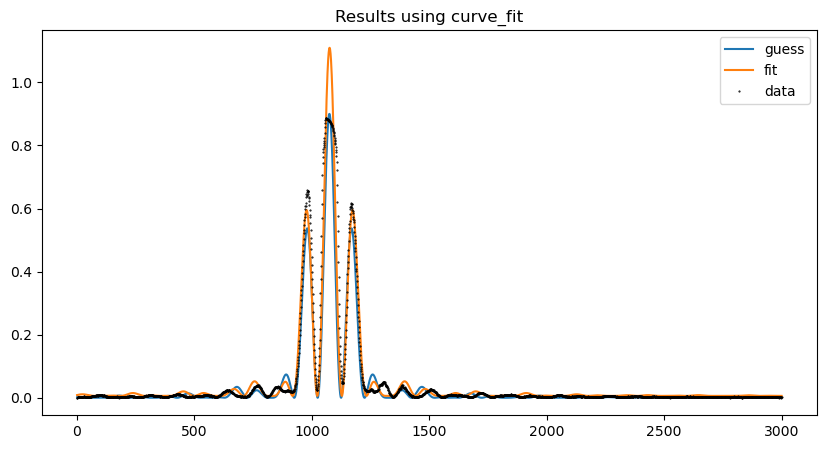

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(data[0],fit(data[0],*guess),label='guess')
ax.plot(data[0],fit(data[0],*result[0]),label='fit')
ax.plot(data[0],data[1],'k.',markersize=1,label='data')
ax.set_title("Results using curve_fit")
ax.legend()

To use the "minimize" family of functions, we need to define a function to calculate the sum of the squared errors (residuals):

In [13]:
def residuals(args,x,y,fit):
    # calculate sum of squared errors for the fitting function
    y_fit = fit(x,*args)
    return ((y-y_fit)**2).sum()

In [14]:
# initial residuals (SSE)
residuals(guess,data[0],data[1],fit)

np.float64(7.403847567631326)

In [15]:
result = opt.minimize(residuals,guess, args=(data[0],data[1],fit)) # using more modern algorithms

#result = opt.least_squares(residuals,guess, args=(data[0],data[1],fit)) # using the traditional levenberg-marquadt algorithm

In [16]:
result.x

array([2.99779203e-02, 1.10362521e+00, 1.31282936e-02, 1.07580688e+03,
       5.95862587e-03])

In [17]:
result.keys()

dict_keys(['fun', 'jac', 'hess_inv', 'nfev', 'njev', 'status', 'success', 'message', 'x', 'nit'])

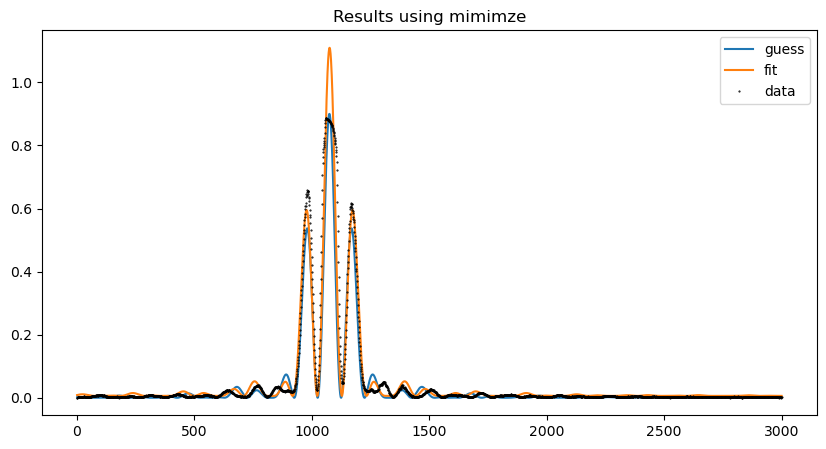

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(data[0],fit(data[0],*guess),label='guess')
ax.plot(data[0],fit(data[0],*result.x),label='fit')
ax.plot(data[0],data[1],'k.',markersize=1,label='data')
ax.set_title("Results using mimimze")
ax.legend()

In [19]:
# final residuals (SSE)
result.fun

np.float64(4.256876707067459)